# 1. Load Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import ResNet50, efficientnet_v2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras import layers

2025-06-27 07:04:29.353828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751007869.570387      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751007869.634876      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. CIFAR-10 Dataset

In [23]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

## Basic Info and Shapes

In [24]:
print(f"Training data shape: {x_train_full.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Training labels shape: {y_train_full.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Training labels shape: (50000, 1)
Test labels shape: (10000, 1)


## Label Mapping

In [25]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 3. EDA

## Visualize Sample Images

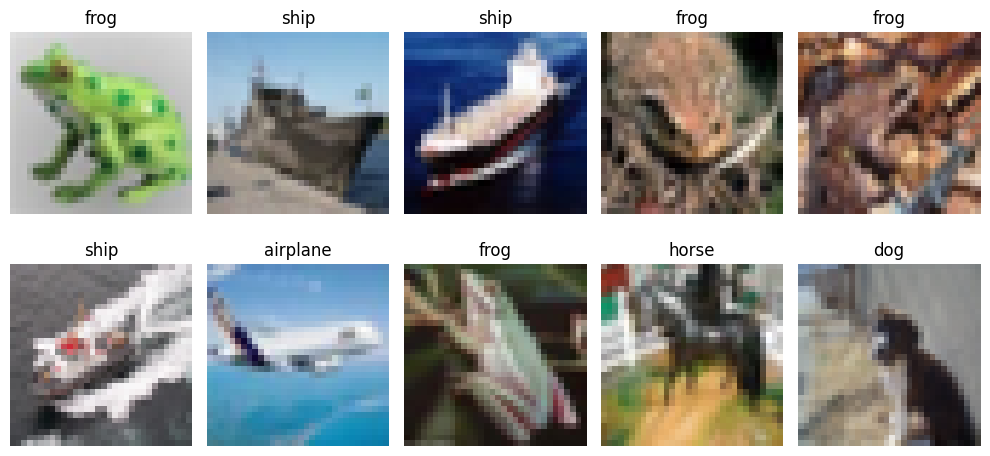

In [27]:
plt.figure(figsize=(10, 5))

for i in range(10):
    idx = np.random.randint(0, len(y_train_full))
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_full[idx])
    plt.title(class_names[y_train_full[idx][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Class Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


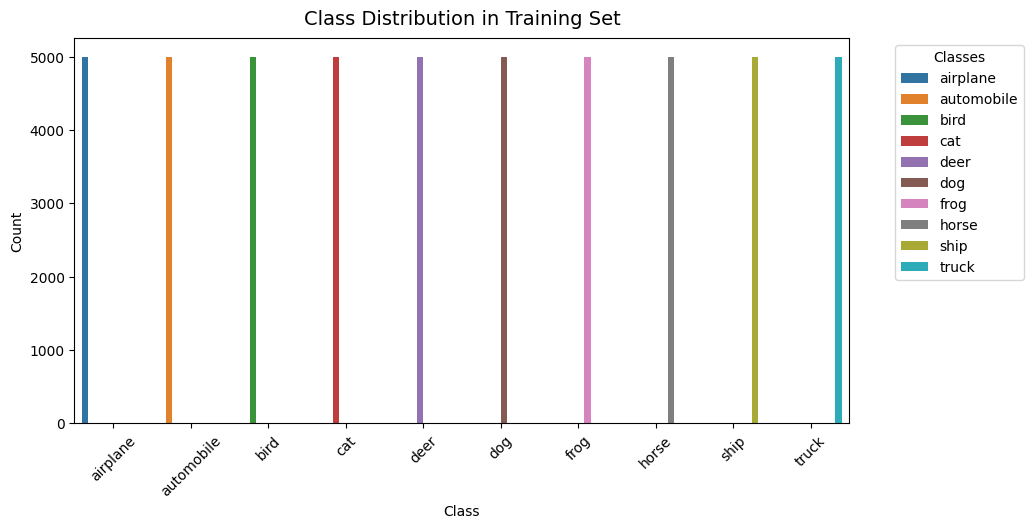

In [53]:
label_counts = pd.Series(y_train_full.flatten()).value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=label_counts.values, hue=class_names, palette='tab10')
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Set", fontsize=14, pad=10)
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Image Statistics

Check pixel intensity range and distribution:

Pixel range:  0 to 255


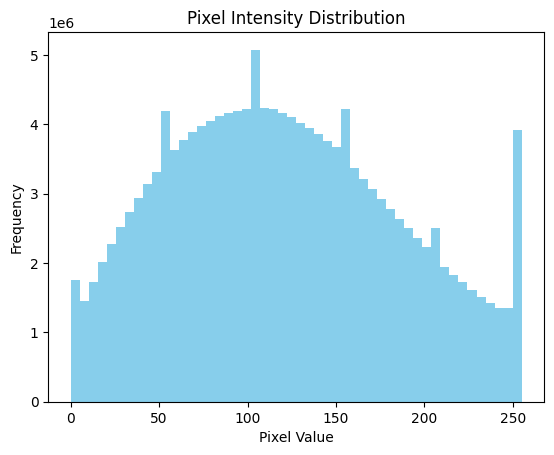

In [54]:
print('Pixel range: ', x_train_full.min() , 'to', x_train_full.max())

plt.hist(x_train_full.flatten(), bins=50, color='skyblue')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

## Check for Duplicates or Anomalies

In [55]:
unique_images = np.unique(X_train.reshape(len(X_train), -1), axis=0)
print(f'Duplicate Images: {len(X_train) - len(unique_images)}')

Duplicate Images: 0


# 4. Preprocessing

## Normalize pixel values

In [4]:
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

## Convert labels to one-hot encoding

In [5]:
num_classes = 10
y_train_full = to_categorical(y_train_full, num_classes)
y_test = to_categorical(y_test, num_classes)

## Split train data into train and validation sets

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

# 5. Build CNN model

In [7]:
cnn_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750984771.170665    1109 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750984771.171372    1109 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,171,178 (8.28 MB)

 Trainable params: 2,169,770 (8.28 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Compile model

In [9]:
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Define Callbacks

In [10]:
checkpoint_cb = ModelCheckpoint(
    filepath='best_cifar10_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

## Train the model

In [11]:
hist = cnn_model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/30


I0000 00:00:1750984785.748603    1158 service.cc:148] XLA service 0x7ddee4008200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750984785.748645    1158 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750984785.748649    1158 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750984786.195835    1158 cuda_dnn.cc:529] Loaded cuDNN version 90300


 18/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1828 - loss: 3.3122  

I0000 00:00:1750984791.072832    1158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4058 - loss: 1.9292
Epoch 1: val_accuracy improved from -inf to 0.62010, saving model to best_cifar10_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.4066 - loss: 1.9255 - val_accuracy: 0.6201 - val_loss: 1.0706 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6257 - loss: 1.0547
Epoch 2: val_accuracy improved from 0.62010 to 0.67020, saving model to best_cifar10_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6257 - loss: 1.0546 - val_accuracy: 0.6702 - val_loss: 0.9561 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6904 - loss: 0.8789
Epoch 3: val_accuracy improved from 0.67020 to 0.70530, saving model to best_cifar10_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6904 - loss: 0.8789 - val_accuracy: 0.7053 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

## Evaluate on test data

In [12]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_acc:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8340 - loss: 0.5653

Test accuracy: 0.83%


## Plot accuracy and loss curves

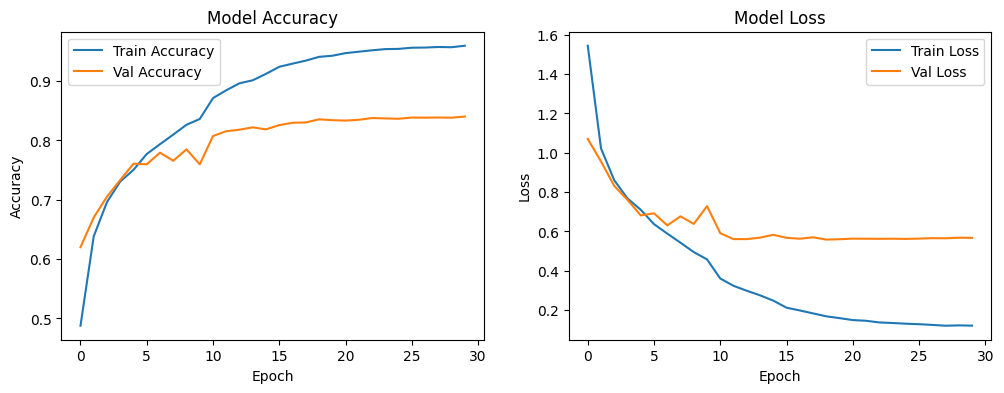

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Predict on test set

In [14]:
y_pred_probs = cnn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


## Classification report

In [15]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.84      0.84      1000
  automobile       0.90      0.92      0.91      1000
        bird       0.80      0.73      0.76      1000
         cat       0.70      0.67      0.68      1000
        deer       0.78      0.83      0.81      1000
         dog       0.77      0.76      0.76      1000
        frog       0.84      0.89      0.86      1000
       horse       0.88      0.87      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.89      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



## Confusion matrix

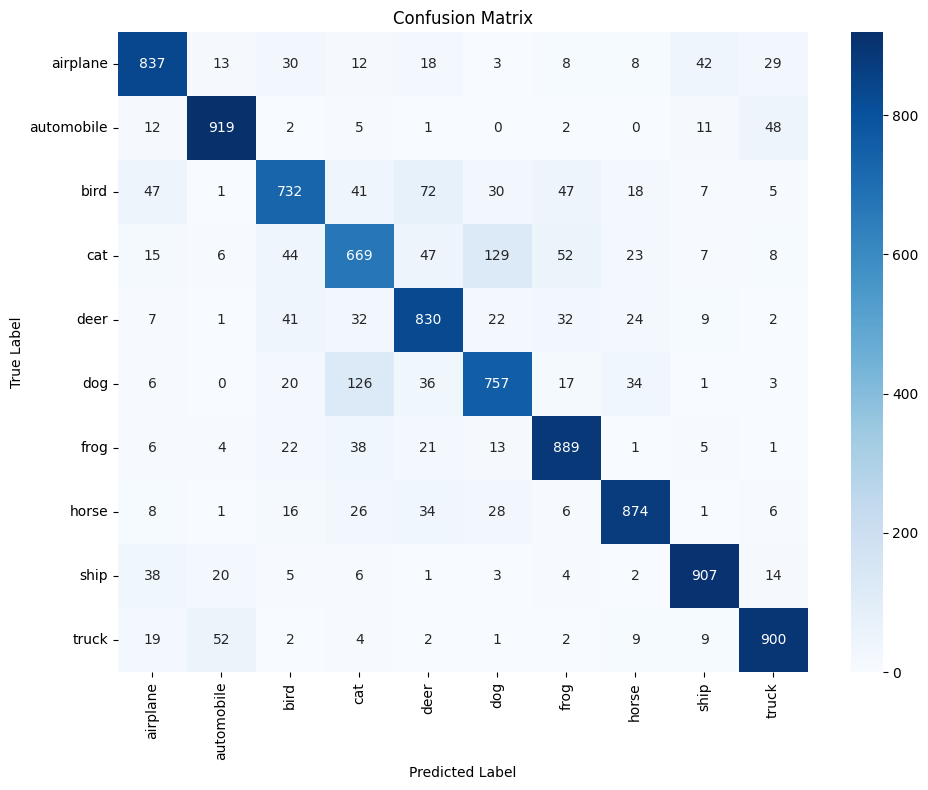

In [16]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# 10. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
], yticklabels=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 6. EfficientNetB0 Model

## Load and preprocess data

In [2]:
(train_data, train_label), (test_data, test_label) = tf.keras.datasets.cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = train_data.astype("float32")
test_data = test_data.astype("float32")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

## Split data to training and validation

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

## Makes data augmentation generator

In [5]:
train_gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_gen.flow(X_train, y_train, batch_size=32)

## Defines EfficientNetV2 model

In [6]:
input_shape = (32, 32, 3) #Cifar10 image size
resized_shape = (224, 224, 3) #EfficientNetV2B0 model input shape
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, resized_shape[:2]))(inputs) #Resize image to  size 224x224
    base_model = efficientnet_v2.EfficientNetV2B0(include_top=False, input_shape=resized_shape, weights="imagenet")
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Training

In [7]:
model = build_model()

I0000 00:00:1751007906.594930      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751007906.595580      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 5,871,514 (22.40 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [9]:
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

In [10]:
model.compile(
    optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [11]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[plateau, earlystopping]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751007956.902850      98 service.cc:148] XLA service 0x7f9d40022150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751007956.904058      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751007956.904077      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751007959.862921      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751007969.726628      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

1020/1172 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.6723 - loss: 0.9624

E0000 00:00:1751008102.490546     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751008102.629788     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 241s 146ms/step - accuracy: 0.6886 - loss: 0.9153 - val_accuracy: 0.9414 - val_loss: 0.1730 - learning_rate: 0.0100
Epoch 2/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 134s 114ms/step - accuracy: 0.8970 - loss: 0.3033 - val_accuracy: 0.9499 - val_loss: 0.1531 - learning_rate: 0.0100
Epoch 3/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 134s 114ms/step - accuracy: 0.9211 - loss: 0.2254 - val_accuracy: 0.9527 - val_loss: 0.1408 - learning_rate: 0.0100
Epoch 4/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 134s 114ms/step - accuracy: 0.9388 - loss: 0.1799 - val_accuracy: 0.9615 - val_loss: 0.1174 - learning_rate: 0.0100
Epoch 5/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9499 - loss: 0.1475
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 134s 114ms/step - accuracy: 0.9499 - loss: 0.1475 - val_accuracy: 0.9598 - val_loss: 0.1237 - learning_rate: 0.0100
Epoch 6/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 134s 114ms/step - accurac

##  Evaluate on test data

In [14]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print(f"Test Accuracy: {test_acc:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9723 - loss: 0.0952
Test Accuracy: 0.97%


## Plot accuracy and loss curves

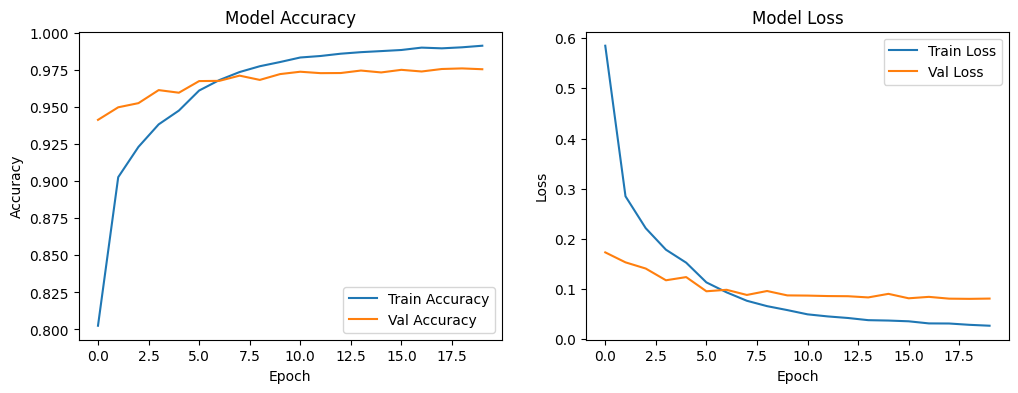

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [18]:
y_pred_probs = model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_label, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


In [19]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.98      0.98      0.98      1000
  automobile       0.98      0.99      0.98      1000
        bird       0.98      0.97      0.97      1000
         cat       0.97      0.91      0.94      1000
        deer       0.97      0.97      0.97      1000
         dog       0.93      0.97      0.95      1000
        frog       0.96      1.00      0.98      1000
       horse       0.99      0.98      0.99      1000
        ship       0.99      0.99      0.99      1000
       truck       0.99      0.97      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



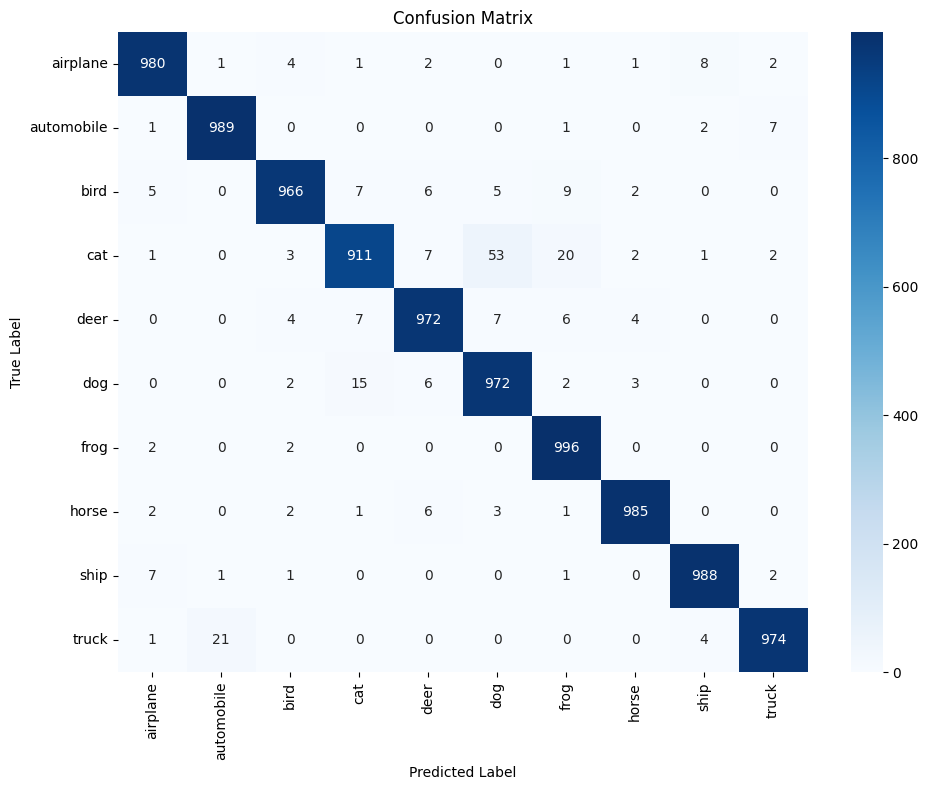

In [20]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# 10. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
], yticklabels=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 7. Save EfficientNet Model

In [21]:
model.save("efficientnet_cifar10.h5")